In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pathlib
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap

In [2]:
rnd_val = 0 # Random value for all seeds
rng = np.random.default_rng(seed=rnd_val) # random number generator

In [3]:
morph_features = 'nf1_sc_norm_fs_all_cellprofiler.csv.gz'

In [4]:
data_dir = pathlib.Path("nf1_data_repo/4_processing_features/data/Plate1/CellProfiler")
data_comp = data_dir / morph_features

In [5]:
# If the file isn't found in the path above then raise an error.
if not data_comp.is_file():
    raise FileNotFoundError(f"File '{data_comp}' does not exist")
    
morph_feat = pd.read_csv(data_comp)

In [6]:
# Creating binary labels for the genotype:
lb = LabelBinarizer()
morph_feat['genotype_label'] = lb.fit_transform(morph_feat['Metadata_genotype'])
featdf = morph_feat # Create a copy for modification

# Selecting Features

In [7]:
feat_col = [col for col in featdf.columns if 'Metadata' not in col] # Select all columns that don't contain the Metadata in their name

featdf = featdf[feat_col]
featdf = featdf.loc[:,featdf.columns != 'Unnamed: 0'] # Remove the unamed column

# Sampling

In [8]:
min_class_samps_size = min(featdf['genotype_label'].value_counts().values)
strat_featdf = featdf.groupby('genotype_label', group_keys=False).apply(lambda x: x.sample(n=min_class_samps_size, random_state=rnd_val))
traindf, testdf = train_test_split(strat_featdf, random_state=rnd_val, shuffle=True, train_size=0.9)

In [9]:
train_feat = traindf.to_numpy()
test_feat = testdf.to_numpy()

# PCA Visualization

Explained variation = 0.21568303448625398


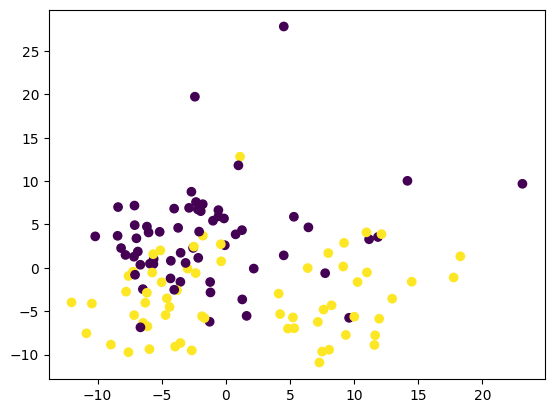

In [10]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(train_feat[:,0:-1])
print(f'Explained variation = {np.sum(pca.explained_variance_ratio_)}')

plt.scatter(pca_features[:,0],pca_features[:,1], c=train_feat[:,-1])
plt.show()

In [11]:
reducer = umap.UMAP(random_state=rnd_val)
reducer.fit(train_feat[:,0:-1])

UMAP(random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

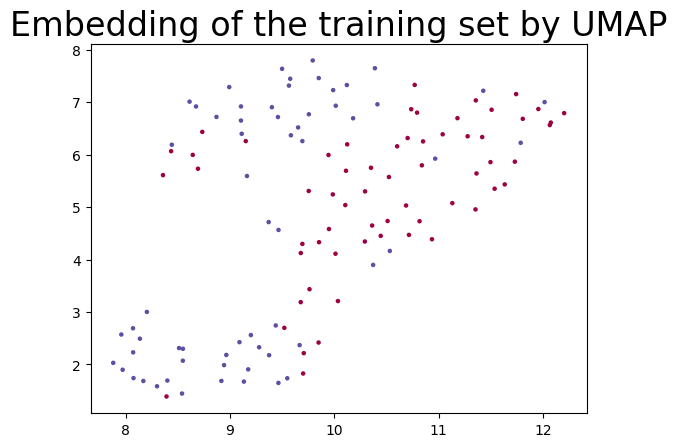

In [12]:
plt.scatter(reducer.embedding_[:, 0], reducer.embedding_[:, 1], s= 5, c=train_feat[:,-1], cmap='Spectral')
plt.title('Embedding of the training set by UMAP', fontsize=24);

# K Cross Validation

In [13]:
num_splits = 5 # Default number of splits

def kcross_val(model, feat, splits=num_splits):

    cv = KFold(n_splits = splits, random_state=rnd_val, shuffle=True)
    max_acc = 0 # Keep track of the maximum accuracy

    for idx, (train_idx, val_idx) in enumerate(cv.split(X=feat)):
        yval = feat[val_idx,-1].astype(np.int64)
        ytrain = feat[train_idx,-1].astype(np.int64)
        Xval = feat[val_idx,0:-1]
        Xtrain = feat[train_idx,0:-1]

        model.fit(Xtrain, ytrain)
        acc = model.score(Xval, yval)

        if max_acc < acc: # Find the model with the best accuracy
            
            max_acc, best_model, best_preds, val_labels = acc, model, model.predict(Xval), yval
    
    res = {'acc':max_acc, 'model':best_model, 'preds':best_preds, 'labels':val_labels} # Store as a dictionary

    return res

In [14]:
# Returns the naive accuracy:
def naive_acc(labels):
    naive_pred = rng.integers(low=0, high=2, size=labels.shape[0])
    naive_acc = accuracy_score(naive_pred,labels)
    return naive_acc

## Confusion Matrix

In [15]:
def conf_mat(model_res, mat_title='Confusion Matrix'):
    cm = confusion_matrix(model_res['labels'],model_res['preds'])
    fig, ax = plt.subplots(figsize=(5,5), dpi=100)
    display = ConfusionMatrixDisplay(cm, display_labels=np.unique(model_res['labels']))
    ax.set(title=mat_title)
    display.plot(ax=ax);

# LRC Model

In [16]:
lrc = LogisticRegression(random_state=rnd_val)

lrc_results = kcross_val(lrc, train_feat)

In [17]:
print(f"Validation model accuracy = {lrc_results['acc']}")
print(f"Naive accuracy = {naive_acc(lrc_results['preds'])}")

Validation model accuracy = 0.88
Naive accuracy = 0.52


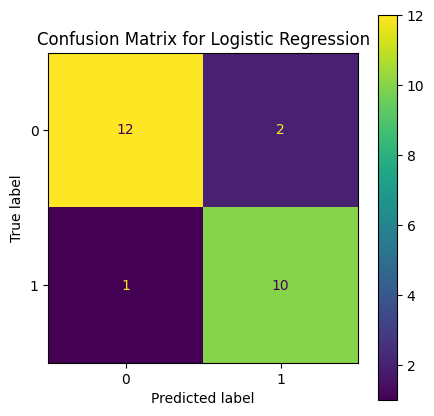

In [18]:
conf_mat(lrc_results, 'Confusion Matrix for Logistic Regression')

In [19]:
lrc_test_acc = lrc.score(test_feat[:,0:-1], test_feat[:,-1].astype(np.int64))
print(f'Logistic Regression Test Accuracy: {lrc_test_acc:.2f}')

Logistic Regression Test Accuracy: 0.79


# Adaboost

In [20]:
adab = AdaBoostClassifier(n_estimators=100, random_state=rnd_val)

adab_results = kcross_val(adab,train_feat)

In [21]:
print(f"Model Validation accuracy = {adab_results['acc']}")
print(f"Naive accuracy = {naive_acc(adab_results['preds'])}")

Model Validation accuracy = 1.0
Naive accuracy = 0.52


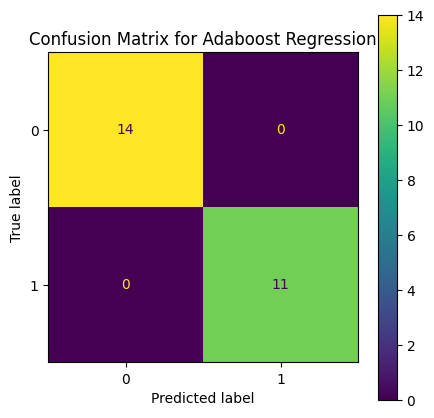

In [22]:
conf_mat(adab_results, 'Confusion Matrix for Adaboost Regression')

In [23]:
adab_test_acc = adab.score(test_feat[:,0:-1], test_feat[:,-1].astype(np.int64))

print(f'Adaboost Test Accuracy: {adab_test_acc}')

Adaboost Test Accuracy: 1.0
